In [3]:
from importlib import reload
import pmagpy.svei as svei
import numpy as np
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline 
import pandas as pd
import wget
import requests
api = 'https://api.earthref.org/v1/MagIC/{}'

## Before using this notebook:
- copy this notebook out of the PmagPy distribution into another directory

## How to use the SVEI module 
- testing PSV data sets against a GGP model
    - GGP models are 'Giant Gaussian Process' models for a statistical description of the  geomagnetic field (see Tauxe and Kent, 2004, https://doi.org/10.1029/145gm08)
    - SVEI uses the THG24 field model, but other published models are also available. 
- for correction of inclination shallowing of sedimentary records
    - inclinations have frequently been corrected using the E/I method described by Tauxe and Kent (2004)
    - Tauxe et al. (XXXXXX) updated the method which is referred to as the SVEI method
    - this notebook illustrates how to use the PmagPy code for this


## How to use PmagPy to test if a data set represents paleosecular variation (PSV)
- create a synthetic dataset from a chosen GGP model and test using svei.svei_test()
- download the PSV10-24 data compilation from the MagIC database
- select a study and GGP model for testing
- run svei.svei_test_varkap for testing

## Example of the two Anderson-Darling tests (A2D,A2I), and the V2dec, and E tests for consistency of a dataset with the THG24 GGP model.

a) Equal area projection of simulated directions drawn from the  model for a  latitude of ~30. Solid symbols are lower hemispheric projections.  Grey contours are the probability densities for directions expected from the model.  The latitude (Lat) listed above the stereonet was calculated from the data based on the average inclination. An infinite kappa implies no uncertainty in the directions. 

b) Empirical cumulative distribution functions (ECDFs) from data drawn from the THG24 model plotted against the  predicted cumulative density functions (CDFs). Solid lines are the CDFs generated by the model for the declinations (red) and inclinations (blue) at the specified latitude and the dotted lines are the ECDFs of the data.  

c) V2decs from the data (solid vertical line) compared to CDF of 1000 datasets drawn from THG24 (red line) at the same latitude as in a). Bounds containing 95% of the data are shown as dotted vertical lines.  

d) Same as c), but for the elongations (E) of the data (solid vertical line) and the simulations (solid blue line). This example passes all four tests.

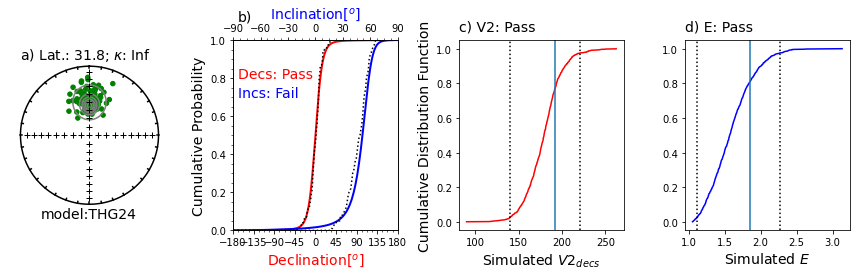

In [5]:
# generate synthetic data set with given GGP model
lat,N,model_name=30,100,'THG24'
# get the model definition
GGPmodel=svei.GGPmodels(model=model_name) 
# see the model definition:
# draw N declinations and inclinations from the model
di_block=svei.GGPrand(GGPmodel,lat,N)
result=svei.svei_test(di_block,plot=True,model_name=model_name)


## download and unpack MagIC contribution for PSV10-24
- The Private contribution for PSV10-24 compilation is magic_id is:'20079' and the share_key is: '716ade67-ef46-43bf-8f70-99c7082871f4' 
    - NB:  This will change to a public contribution on publication of this paper
- download the contribution with ipmag.download_magic_from_id()
    - the directory PSV10-24 will be created if it does not already exist.
    - the downloaded file will be put into the  PSV10-24 directory
- use ipmag.download_magic() to unpack it
- run the svei.py module functions to see if the data represent PSV
    - read in the site level data for a particular study
        - Quidelleur et al., 2009 (passes)
        - Calvo-Rathert et al., 2009 (fails)
    - create the di_block array
    - run svei.svei_test_varkap()

In [14]:
reload(ipmag)
magic_id='20079'
share_key='716ade67-ef46-43bf-8f70-99c7082871f4'
dir_path='PSV10-24/'
magic_contribution='magic_contribution_'+magic_id+'.txt'
#ipmag.download_magic_from_id(api.format('data'), params={'id': magic_id,'key':share_key})
ipmag.download_magic_from_id(magic_id,directory=dir_path,share_key=share_key)
ipmag.download_magic(magic_contribution,input_dir_path=dir_path,dir_path=dir_path,print_progress=False) 


1  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/PSV10-24/contribution.txt
80  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/PSV10-24/locations.txt
2441  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/PSV10-24/sites.txt


True

### Same as first figure but for a dataset from PSV10-24 Quidelleur et al., (2009), using model THG24. 
This data set was deemed compatible with the model.

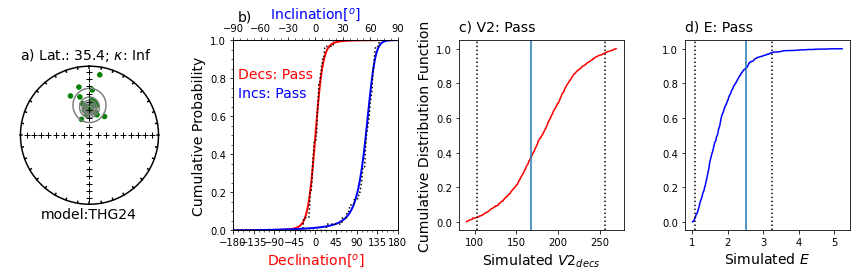

In [16]:
dir_path='PSV10-24'
example_data_doi='10.1016/j.pepi.2008.09.012'# data of Quidelleur et al, 2009)
# read in MagIC formatted PSV10-24 data compilation
df=pd.read_csv(dir_path+'/sites.txt',sep='\t',header=1)
# pick out desired example
df=df[df['citations'].str.contains(example_data_doi)]
# use svei.svei_test to see if consistent with data model
# first pick out the directional data and put in array
di_block=df[['dir_dec','dir_inc']].values
# do the test and make the plot
resdict=svei.svei_test_varkap(di_block,plot=True)


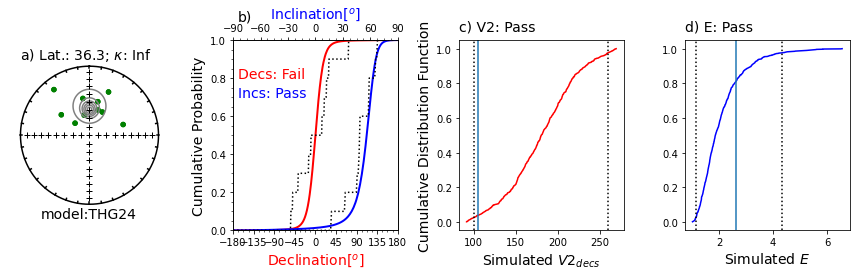

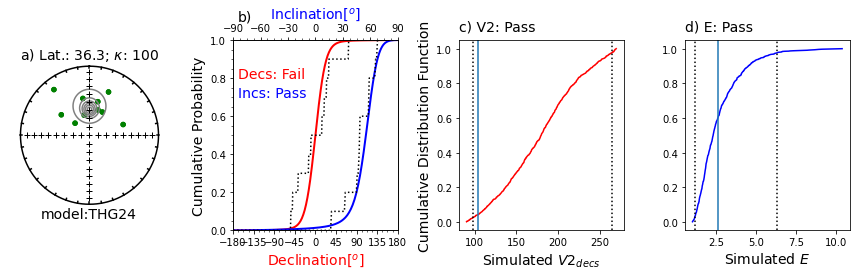

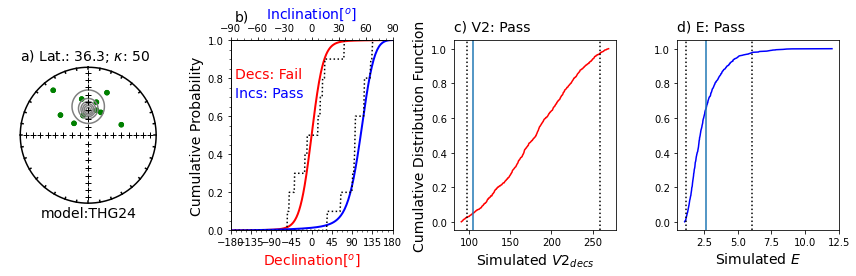

In [17]:
# here's one that fails the compatibility test:
example_data_doi='10.1186/BF03352885'# data of Calvo-Rathert et al., 2009)
# read in MagIC formatted PSV10-24 data compilation
df=pd.read_csv(dir_path+'/sites.txt',sep='\t',header=1)
# pick out desired example
df=df[df['citations'].str.contains(example_data_doi)]
# use svei.svei_test to see if consistent with data model
# first pick out the directional data and put in array
di_block=df[['dir_dec','dir_inc']].values
# do the test and make the plot
resdict=svei.svei_test_varkap(di_block,plot=True)


## Use svei.py module to correct inclination shallowing
- create directory for example data set
- download data set of Gilder et al., 2001 (doi: 10.1029/2001JB000325)
    - oops this only has data for MAD <10....   
- do reversals test of Heslop et al., 2023
- filter data for MAD<10
- repeat reversals test
- run svei.find_flat()


In [29]:
# download data from MagIC
dir_path='find_flat'
dirs=os.listdir()
if dir_path not in dirs:
    os.mkdir(dir_path) # create directory if needed
else:
    print (dir_path + ' already created')

reference_doi = '10.1029/2001JB000325'
magic_contribution='magic_contribution.txt' # default filename for downloaded file
ipmag.download_magic_from_doi(reference_doi)
os.rename(magic_contribution, dir_path+'/'+magic_contribution) # move to dir_path
# unpack the file
ipmag.download_magic(magic_contribution,dir_path=dir_path,print_progress=False)

find_flat already created
20080/magic_contribution_20080.txt extracted to magic_contribution.txt 

1  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/find_flat/contribution.txt
1  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/find_flat/locations.txt
140  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/find_flat/sites.txt
140  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/find_flat/samples.txt
140  records written to file  /Users/ltauxe/Dropbox/4Stuart/Code_for_paper/SVEI_demo_notebook/find_flat/specimens.txt


Heslop et al. (2023) test statistic value = 10.91
Heslop et al. (2023) critical test statistic value = 12.51
Estimated p-value = 0.07
Cannot reject null of common means at alpha = 0.05 confidence level


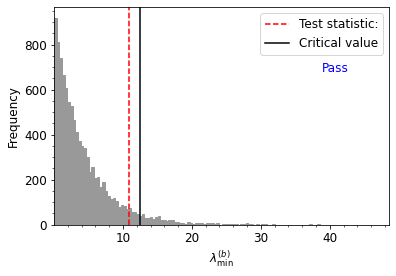

(1, 10.906970117468518, 12.506750845655294, 0.07329267073292671)

In [15]:
# read site level data from publication
dir_path='find_flat'
df=pd.read_csv(dir_path+'/sites.txt',sep='\t', header=1)
# first pick out the directional data and put in array
di_block=df[['dir_dec','dir_inc']].values
# do the reversals test of Heslop et al. (2023)
ipmag.reversal_test_bootstrap_H23(di_block=di_block,plot=True)


using model:  THG24


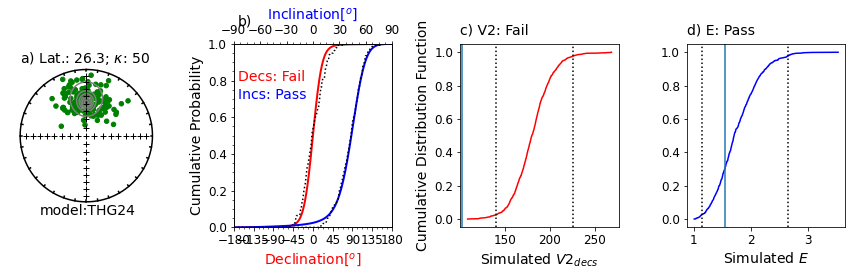

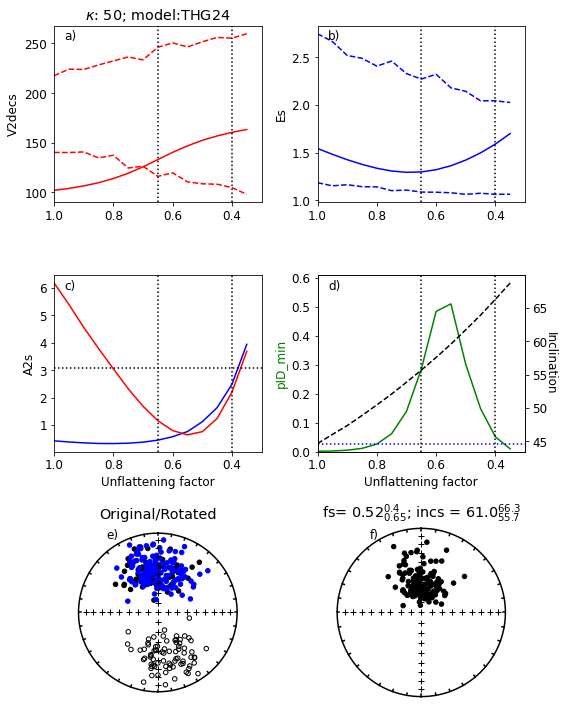

In [16]:
# if data pass the reversals test, then do this:
# try 'quick' version first: 
# Code first tests if data are compatible with GGP model
# if they are, then you don't try unflattening them
# if they aren't then you try...   
quick=True
if quick: # not exactly quick but quicker than not quick...  
    flat_df=svei.find_flat(di_block,plot=True,quick=quick)
    # then the full way (much slower, but way better)


using model:  THG24


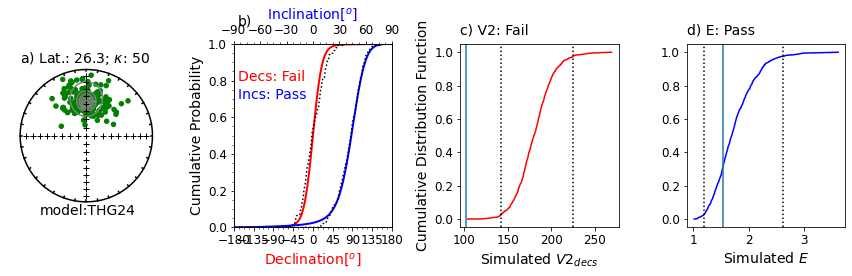

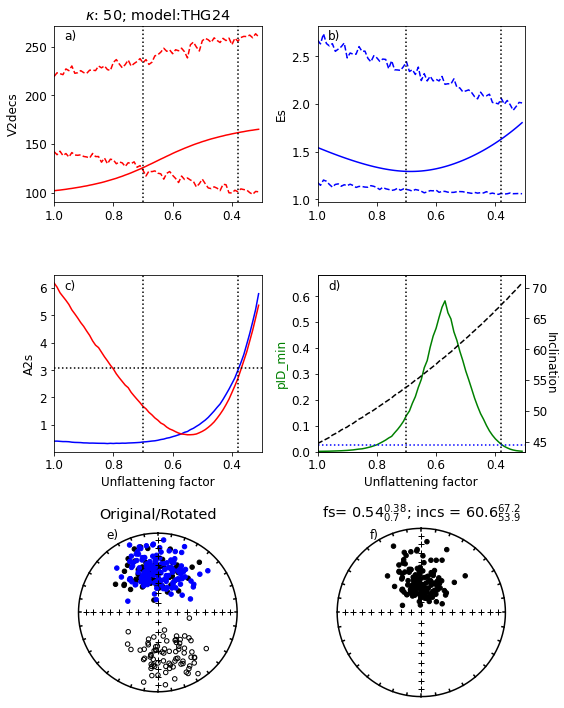

In [17]:
# if 'quick' results are promising, do the full way
# this is slower, but much more reliable and gives better confidence bounds
quick=False
verbose=False
flat_df=svei.find_flat(di_block,plot=True,quick=quick,verbose=verbose)

